In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize
import logging
import sys
import tensorflow as tf
import sys; #sys.path.append('../')
from src.models.unet_dilation_deep_original import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef
import cv2
import numpy as np
import cv2
import glob
import random
from PIL import Image
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from src.utils.model import dice_coef, jaccard_coef,tru_pos,fls_pos,tru_neg,fls_neg


sns.set_style("whitegrid", {'axes.grid' : False})
import keras

Using TensorFlow backend.
/apps/well/python/3.5.2-gcc5.4.0/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Our predictions will be in pixels, the microns per pixel conversion factor for these images is 0.615346875

In [2]:
julius_imgs = glob.glob('/well/lindgren/craig/Julius_histology/*/*')

In [3]:
julius_imgs[0:10]

['/well/lindgren/craig/Julius_histology/m230/m230_VC_ (5).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_SC_ (1).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (7).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (8).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (13).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_SC_ (5).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (16).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_SC_ (7).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (4).tif',
 '/well/lindgren/craig/Julius_histology/m230/m230_VC_ (20).tif']

In [4]:
print('Number of histology images from 220 individuals: {}'.format(len(julius_imgs)))

Number of histology images from 220 individuals: 6158


In [5]:
#model = UNet()
model = UNet('unet')
model.config['data_path'] = '.'
model.load_data()

In [6]:
gpu_selection(visible_devices="3")
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)

In [7]:
model.compile() # THIS IS USING BEST VALIDATION LOSS WEIGHTS :]
model.net.load_weights('/well/lindgren/craig/isbi-2012/checkpoints/unet_1024_dilation/weights_loss_val.weights')
# model.net.summary()

Out of sample prediction on an image neither trained nor validated on.

In [8]:
def norm_img(img,mean,std):
    out=[]
    test_sample = np.array(img,np.float32)
    test_sample= (test_sample - mean) / (std + 1e-10)
    out.append(test_sample)
    out=np.array(out)
    return(out)

In [9]:
def predict_julius_areas(prd_batch):
    blobs = np.where(prd_batch[0] > 0.30, 0, 1)
    blobs = np.array(cv2.erode((blobs *1.0).astype(np.float32),np.ones((3,3))),dtype='int8')
    blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((5,5))).astype(int)
    labels, no_objects = ndimage.label(blobs)
    props = regionprops(blobs)
    labelled=ndimage.label(blobs)
    resh_labelled=labelled[0].reshape((img.shape[0],img.shape[1])) #labelled is a tuple: only the first element matters
    props=regionprops(resh_labelled) 
    size={i:props[i].area for i in range (0, no_objects)}
    no_of_cells=(sum(i > 200 and i < 100000 for i in size.values()))
    areas=[i for i in size.values() if i >= 200 and i <= 100000]
    areas=np.array(areas)
    return(blobs,np.median(areas),np.mean(areas),np.std(areas),no_of_cells)
    



In [12]:
from skimage import img_as_uint
import time
start = time.time()
import os
import os.path
out_batch=[]
j=0
with open('Julius_adipocyte_preds.csv','a') as out_file:
    for jul_img in tqdm.tqdm(julius_imgs):
        if os.path.isfile('predicted_masks/julius/'+str(jul_img.split('/')[6])+'mask.png'):
            pass
        else:
            width = 1024
            height = 768
            img=Image.open(jul_img).convert('L')
            img = img.resize((1024,768))
            img = np.array(img.crop((width-1024,height-1024,width,height)))
            img_mean, img_stdev = np.mean(img), np.std(img)
            normalised_img = np.expand_dims((img - np.mean(img)) / np.std(img),0)
            prd_batch = model.net.predict(normalised_img,batch_size=1)
            blobs,median_area,mean_area,std_area,no_cells = predict_julius_areas(prd_batch)
            if j ==0:
                out_file.write('image,median_area,mean_area,std_dev_area,no_cells\n')
                imsave('predicted_masks/julius/'+str(jul_img.split('/')[6])+'mask.png',blobs)
            else:
                out_file.write(str(jul_img)+','+str(median_area)+','+str(mean_area)+','+str(std_area)+','+str(no_cells) + '\n')
                imsave('predicted_masks/julius/'+str(jul_img.split('/')[6])+'mask.png',blobs)
        j+=1
    end = time.time()
    print('Total time taken {}'.format(end-start))

100%|██████████| 6158/6158 [01:51<00:00, 55.22it/s]

Total time taken 111.62290096282959


In [33]:
width = 1024
height = 768
img=Image.open(julius_imgs[100]).convert('L')
img = img.resize((1024,768))
img = np.array(img.crop((width-1024,height-1024,width,height)))
img_mean, img_stdev = np.mean(img), np.std(img)
normalised_img = norm_img(img,img_mean,img_stdev)
prd_batch = model.net.predict(normalised_img,batch_size=1)
blobs,median_area,mean_area,std_area,no_cells = predict_julius_areas(prd_batch)

In [34]:
prd_batch = model.net.predict(normalised_img,batch_size=1)

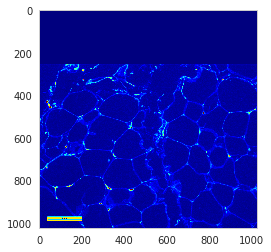

In [35]:
plt.imshow(img,cmap='jet')

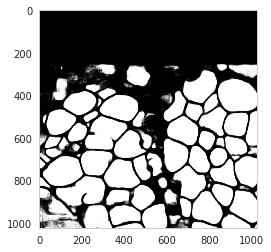

In [36]:
plt.imshow(prd_batch[0])

In [37]:
blobs = np.where(prd_batch[0] > 0.30, 0, 1)
blobs = np.array(cv2.erode((blobs *1.0).astype(np.float32),np.ones((3,3))),dtype='int8')


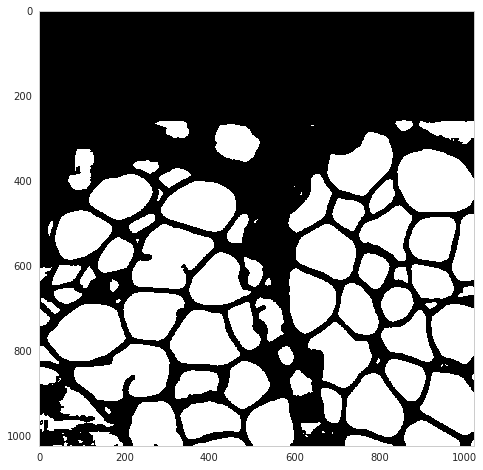

In [38]:
blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((3,3))).astype(int)
plt.figure(figsize=(8,8))
plt.imshow(blobs,cmap='gray')